In [1]:
%load_ext autoreload
%autoreload 1
%aimport analysis

from analysis import *
import pingouin as pg

testType = 'wilcoxon'

(Re)loading load_data
(Re)loading analysis


In [2]:
behavior['afterNonPref'] = \
    (behavior.session=='experiment') & \
    (behavior.subjectId.shift()==behavior.subjectId) & \
    (behavior.session.shift()==behavior.session) & \
    (behavior.direction.shift()!=behavior.preferred.shift()) & \
    (behavior.condType!='filler')

In [3]:
print('Number of test trials when the stone was in the non-preferred hand in the last preceeding filler')
behavior.query('afterNonPref & ~excluded').groupby('condType').trialCount.count()

Number of test trials when the stone was in the non-preferred hand in the last preceeding filler


condType
blush      6
hint      11
normal     4
wink      13
Name: trialCount, dtype: int64

In [4]:
print('Number of participants having test trials when the stone was in the non-preferred hand in the last preceeding filler')
behavior.query('afterNonPref & ~excluded').groupby(['subjectId', 'condType'], as_index=False).first().groupby('condType').subjectId.count()

Number of participants having test trials when the stone was in the non-preferred hand in the last preceeding filler


condType
blush      6
hint      10
normal     4
wink      12
Name: subjectId, dtype: int64

In [5]:
testTrials = behavior.query("(session=='experiment') & ~excluded").copy()
testTrials.condType = testTrials.apply(lambda r: r.condType + ('_after_nonpref' if r.afterNonPref else '_after_pref'), axis=1)
pupils = samples.merge(testTrials, left_on=['subjectId', 'session', 'Trial'], right_on=['subjectId', 'session', 'trialCount'])

In [6]:
corrPupils = baselineCorrect(pupils)

stat_fun(H1): min=-1.8257418583505538 max=-0.0
Running initial clustering …
Found 0 clusters


C:\Work\winkorblush\analysis\analysis.py:56: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  _, clusters, cluster_p_values, _ = permutation_cluster_1samp_test(


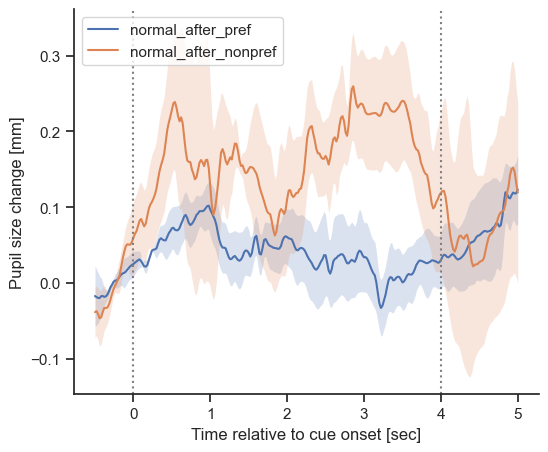

stat_fun(H1): min=-1.804268443271293 max=-0.0
Running initial clustering …
Found 0 clusters


C:\Work\winkorblush\analysis\analysis.py:56: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  _, clusters, cluster_p_values, _ = permutation_cluster_1samp_test(


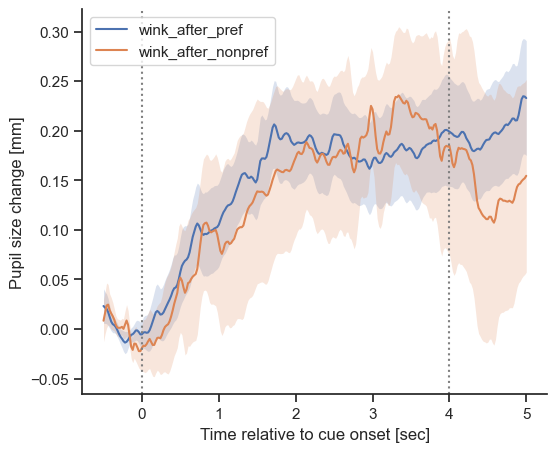

stat_fun(H1): min=-1.376047416881589 max=-0.050964719143762556
Running initial clustering …
Found 0 clusters


C:\Work\winkorblush\analysis\analysis.py:56: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  _, clusters, cluster_p_values, _ = permutation_cluster_1samp_test(


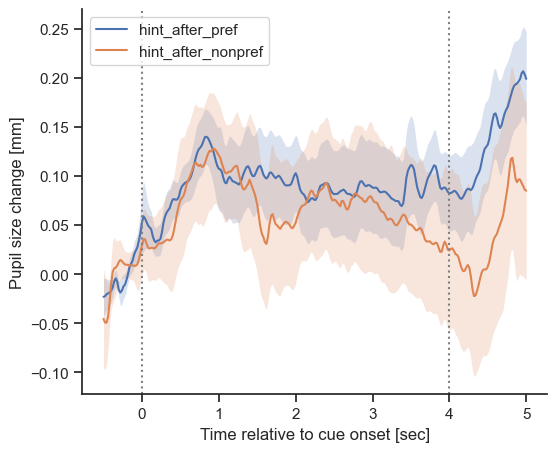

stat_fun(H1): min=-2.2013981571160284 max=-0.10482848367219183
Running initial clustering …
Found 2 clusters


  0%|          | Permuting (exact test) : 0/31 [00:00<?,       ?it/s]

Non-significant cluster from -0.5 to -0.42 seconds (p=0.625).
Non-significant cluster from -0.32 to -0.2 seconds (p=0.5625).


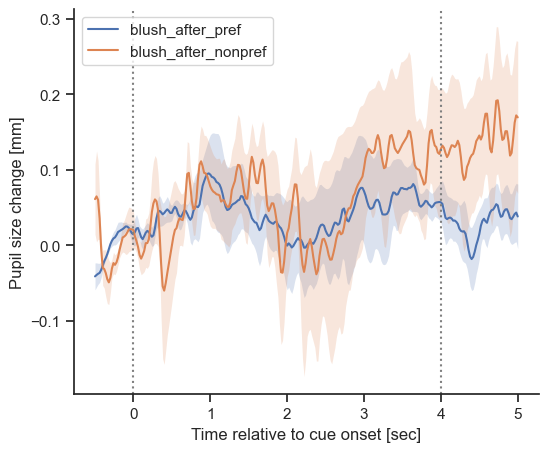

In [7]:
for condType in condTypes:
    condAfterPref, condAfterNonPref = f'{condType}_after_pref', f'{condType}_after_nonpref'
    subjectsWithAfterNonPref = testTrials.query('condType==@condAfterNonPref').subjectId.unique()
    compareWithinSubject(
        corrPupils.query('subjectId in @subjectsWithAfterNonPref'), condAfterPref, condAfterNonPref,
        testType=testType, condColors={condAfterPref: 'C0', condAfterNonPref: 'C1'})
    plt.show()

In [8]:
for condType in condTypes:
    condAfterPref, condAfterNonPref = f'{condType}_after_pref', f'{condType}_after_nonpref'
    subjectsWithAfterNonPref = testTrials.query('condType==@condAfterNonPref').subjectId.unique()
    
    fields = ['subjectId', 'session', 'condType', 'trialCount']
    for field, startTime, endTime in [('earlyPupil', '1s', '2s'), ('latePupil', '3s', '4s')]:
        response = corrPupils[ \
            corrPupils.condType.isin([condAfterPref, condAfterNonPref]) & \
            corrPupils.subjectId.isin(subjectsWithAfterNonPref) & \
            corrPupils.offsetFromStim.between(pd.to_timedelta(startTime), pd.to_timedelta(endTime))]
        pp = response.groupby(fields).Pupil.mean().groupby(fields[:-1]).mean().unstack('condType')

        res = pg.ttest(pp[condAfterPref], pp[condAfterNonPref], paired=True)
        display(res.style.set_caption(f'Condition: {condType}, field: {field}, subjects: {len(subjectsWithAfterNonPref)}'))

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.260396,3,two-sided,0.296644,[-0.28 0.12],0.801359,0.724,0.206090


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.912094,3,two-sided,0.151813,[-0.48 0.12],1.637981,1.121,0.599836


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.546610,11,two-sided,0.595560,[-0.11 0.18],0.153574,0.327,0.077596


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.287340,11,two-sided,0.779192,[-0.21 0.16],0.105448,0.298,0.062916


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.408041,9,two-sided,0.692780,[-0.11 0.17],0.159307,0.332,0.073746


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.564322,9,two-sided,0.586321,[-0.12 0.21],0.230010,0.354,0.100050


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.286969,5,two-sided,0.785648,[-0.17 0.14],0.149435,0.386,0.060496


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.967998,5,two-sided,0.377504,[-0.23 0.11],0.404551,0.535,0.128499
